## 1. Setup and Configuration

In [3]:
# Import libraries
import os
import sys
import pickle
import time
import json
import warnings
import psutil
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    precision_score, recall_score, classification_report
)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [7]:
# Configuration for ELECTRA model
CONFIG = {
    # Model configuration
    'model_name': 'google/electra-base-discriminator',
    'num_labels': 5,
    'max_seq_length': 64,
    
    # Training configuration
    'batch_size': 32,
    'learning_rate': 2e-5,
    'epochs': 10,
    'warmup_steps': 500,
    'weight_decay': 0.01,
    'max_grad_norm': 1.0,
    
    # Data configuration
    'data_dir': '/kaggle/input/sst5-dataset',
    'seed': 42,
    'num_workers': 0,
    
    # Saving configuration
    'save_dir': '/kaggle/working/saved_models/electra',
    'log_dir': '/kaggle/working/logs/electra',
    
    # Label mapping
    'label_list': {
        0: "Very Negative",
        1: "Negative", 
        2: "Neutral",
        3: "Positive",
        4: "Very Positive"
    }
}

# Create directories
os.makedirs(CONFIG['save_dir'], exist_ok=True)
os.makedirs(CONFIG['log_dir'], exist_ok=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device: cuda
GPU Memory: 17.06 GB


## 2. Data Preprocessing - SST-5 Data Loading & Analysis
### Data preprocessing includes:
- Loading raw SST-5 data
- Sentence length analysis
- Tokenization with ELECTRA tokenizer
- Class distribution analysis

In [8]:
def load_sst5_data(data_dir: str) -> Tuple[List[str], List[int], List[str], List[int], List[str], List[int]]:
    """
    Load SST-5 data from CSV files
    
    Args:
        data_dir: Directory containing train.csv, dev.csv, test.csv
        
    Returns:
        Tuple of (train_texts, train_labels, dev_texts, dev_labels, test_texts, test_labels)
    """
    
    train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
    dev_df = pd.read_csv(os.path.join(data_dir, 'dev.csv'))
    test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))
    
    train_texts = train_df['sentence'].tolist()
    train_labels = train_df['label'].tolist()
    
    dev_texts = dev_df['sentence'].tolist()
    dev_labels = dev_df['label'].tolist()
    
    test_texts = test_df['sentence'].tolist()
    test_labels = test_df['label'].tolist()
    
    return train_texts, train_labels, dev_texts, dev_labels, test_texts, test_labels

# Load data
train_texts, train_labels, dev_texts, dev_labels, test_texts, test_labels = load_sst5_data(CONFIG['data_dir'])

print(f"Train samples: {len(train_texts)}")
print(f"Dev samples: {len(dev_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"\nClass distribution (Train):")
print(pd.Series(train_labels).value_counts().sort_index())

Train samples: 8544
Dev samples: 1101
Test samples: 2210

Class distribution (Train):
0    1092
1    2218
2    1624
3    2322
4    1288
Name: count, dtype: int64


In [9]:
# Analyze sentence lengths
def analyze_sentence_lengths(texts: List[str], split_name: str = "Dataset"):
    """
    Analyze and visualize sentence length statistics
    """
    lengths = [len(text.split()) for text in texts]
    
    stats = {
        'min': min(lengths),
        'max': max(lengths),
        'mean': np.mean(lengths),
        'std': np.std(lengths),
        'median': np.median(lengths),
        'p75': np.percentile(lengths, 75),
        'p90': np.percentile(lengths, 90),
        'p95': np.percentile(lengths, 95)
    }
    
    print(f"\n{split_name} - Sentence Length Statistics:")
    print(f"  Min: {stats['min']}, Max: {stats['max']}")
    print(f"  Mean: {stats['mean']:.2f}, Std: {stats['std']:.2f}")
    print(f"  Median: {stats['median']:.2f}")
    print(f"  75th percentile: {stats['p75']:.2f}")
    print(f"  90th percentile: {stats['p90']:.2f}")
    print(f"  95th percentile: {stats['p95']:.2f}")
    
    return lengths, stats

train_lengths, train_stats = analyze_sentence_lengths(train_texts, "Train")
dev_lengths, dev_stats = analyze_sentence_lengths(dev_texts, "Dev")
test_lengths, test_stats = analyze_sentence_lengths(test_texts, "Test")


Train - Sentence Length Statistics:
  Min: 2, Max: 52
  Mean: 19.14, Std: 9.31
  Median: 18.00
  75th percentile: 25.00
  90th percentile: 32.00
  95th percentile: 35.00

Dev - Sentence Length Statistics:
  Min: 2, Max: 49
  Mean: 19.32, Std: 8.86
  Median: 19.00
  75th percentile: 26.00
  90th percentile: 32.00
  95th percentile: 35.00

Test - Sentence Length Statistics:
  Min: 2, Max: 56
  Mean: 19.19, Std: 8.99
  Median: 18.00
  75th percentile: 25.00
  90th percentile: 31.00
  95th percentile: 35.00


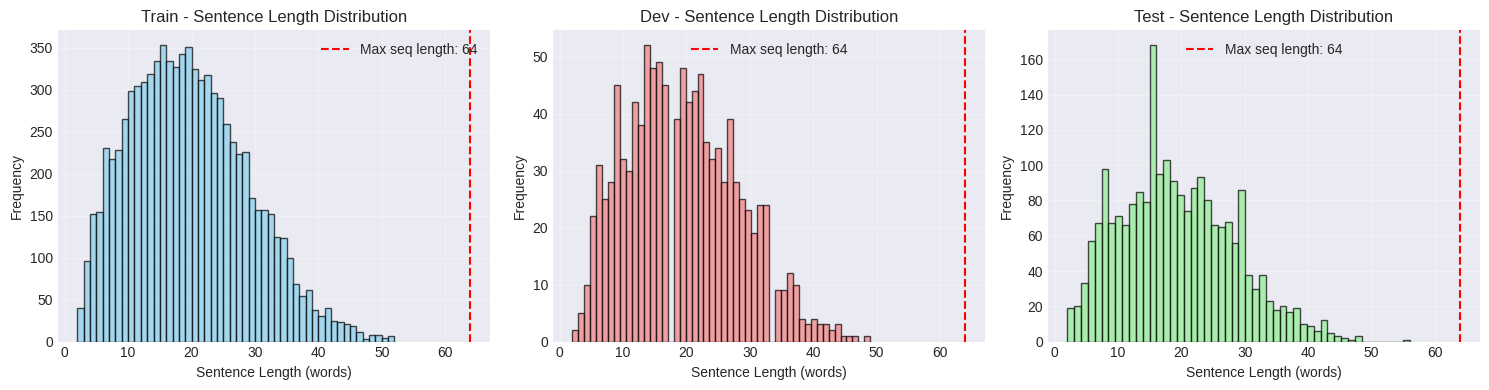


Sentences exceeding max_seq_length (64):
  Train: 0 (0.00%)
  Dev: 0 (0.00%)
  Test: 0 (0.00%)


In [10]:
# Visualize sentence length distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(train_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(CONFIG['max_seq_length'], color='red', linestyle='--', label=f"Max seq length: {CONFIG['max_seq_length']}")
axes[0].set_xlabel('Sentence Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Train - Sentence Length Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(dev_lengths, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(CONFIG['max_seq_length'], color='red', linestyle='--', label=f"Max seq length: {CONFIG['max_seq_length']}")
axes[1].set_xlabel('Sentence Length (words)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Dev - Sentence Length Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].hist(test_lengths, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].axvline(CONFIG['max_seq_length'], color='red', linestyle='--', label=f"Max seq length: {CONFIG['max_seq_length']}")
axes[2].set_xlabel('Sentence Length (words)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Test - Sentence Length Distribution')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['log_dir'], 'sentence_length_distribution.png'), dpi=100, bbox_inches='tight')
plt.show()

print(f"\nSentences exceeding max_seq_length ({CONFIG['max_seq_length']}):")
print(f"  Train: {sum(1 for l in train_lengths if l > CONFIG['max_seq_length'])} ({100*sum(1 for l in train_lengths if l > CONFIG['max_seq_length'])/len(train_lengths):.2f}%)")
print(f"  Dev: {sum(1 for l in dev_lengths if l > CONFIG['max_seq_length'])} ({100*sum(1 for l in dev_lengths if l > CONFIG['max_seq_length'])/len(dev_lengths):.2f}%)")
print(f"  Test: {sum(1 for l in test_lengths if l > CONFIG['max_seq_length'])} ({100*sum(1 for l in test_lengths if l > CONFIG['max_seq_length'])/len(test_lengths):.2f}%)")

['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']


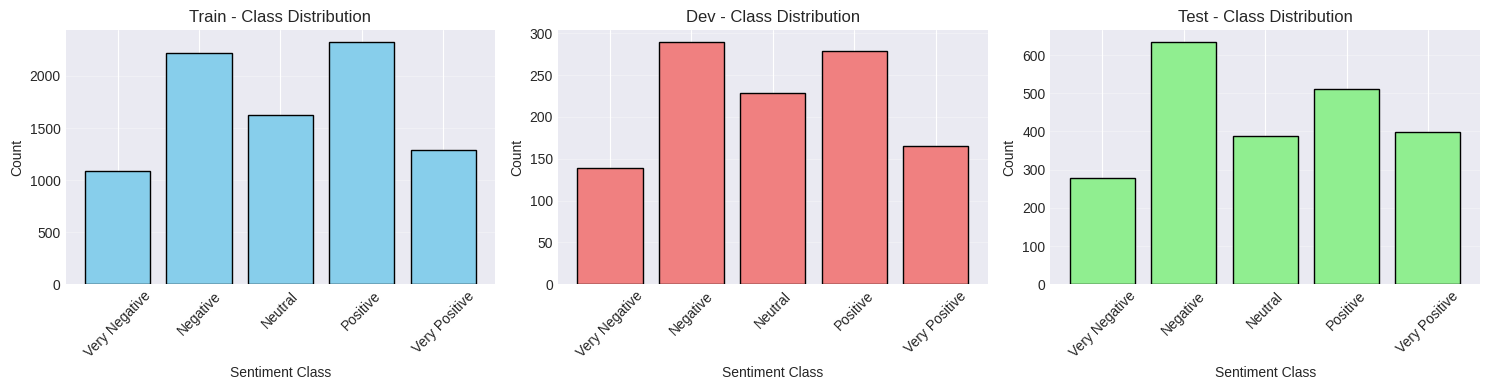

In [19]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
label_names = [CONFIG['label_list'][i] for i in range(CONFIG['num_labels'])]

print(label_names)

train_counts = pd.Series(train_labels).value_counts().sort_index()
dev_counts = pd.Series(dev_labels).value_counts().sort_index()
test_counts = pd.Series(test_labels).value_counts().sort_index()

axes[0].bar(range(CONFIG['num_labels']), [train_counts.get(i, 0) for i in range(CONFIG['num_labels'])], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Sentiment Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Train - Class Distribution')
x = range(CONFIG['num_labels'])
axes[0].set_xticks(x)
axes[0].set_xticklabels(label_names, rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(range(CONFIG['num_labels']), [dev_counts.get(i, 0) for i in range(CONFIG['num_labels'])], color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Sentiment Class')
axes[1].set_ylabel('Count')
axes[1].set_title('Dev - Class Distribution')
x = range(CONFIG['num_labels'])
axes[1].set_xticks(x)
axes[1].set_xticklabels(label_names, rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(range(CONFIG['num_labels']), [test_counts.get(i, 0) for i in range(CONFIG['num_labels'])], color='lightgreen', edgecolor='black')
axes[2].set_xlabel('Sentiment Class')
axes[2].set_ylabel('Count')
axes[2].set_title('Test - Class Distribution')
x = range(CONFIG['num_labels'])
axes[2].set_xticks(x)
axes[2].set_xticklabels(label_names, rotation=45)

axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['log_dir'], 'class_distribution.png'), dpi=100, bbox_inches='tight')
plt.show()

## 3. Dataset and DataLoader

In [ ]:
class SST5Dataset(Dataset):
    """
    Custom Dataset for SST-5 with tokenization
    """
    
    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_length: int = 64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

# Create datasets
train_dataset = SST5Dataset(train_texts, train_labels, tokenizer, CONFIG['max_seq_length'])
dev_dataset = SST5Dataset(dev_texts, dev_labels, tokenizer, CONFIG['max_seq_length'])
test_dataset = SST5Dataset(test_texts, test_labels, tokenizer, CONFIG['max_seq_length'])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'])
dev_loader = DataLoader(dev_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])

print(f"Train batches: {len(train_loader)}")
print(f"Dev batches: {len(dev_loader)}")
print(f"Test batches: {len(test_loader)}")

## 4. Model Initialization

In [ ]:
# Initialize model
model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=CONFIG['num_labels']
)

# Move to device and ensure float32 precision
model = model.to(device)
model = model.float()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model dtype: {next(model.parameters()).dtype}")
print(f"Device: {device}")

In [ ]:
# Setup optimizer and scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

total_steps = len(train_loader) * CONFIG['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=CONFIG['warmup_steps'],
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {CONFIG['warmup_steps']}")

## 5. Training Loop with Metrics Tracking

In [ ]:
def train_epoch(model, train_loader, optimizer, scheduler, device, epoch, total_epochs):
    """
    Train one epoch and return metrics
    """
    model.train()
    
    total_loss = 0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}")
    
    for batch in pbar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device).long()
        attention_mask = batch['attention_mask'].to(device).long()
        labels = batch['labels'].to(device).long()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        # Get predictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['max_grad_norm'])
        
        optimizer.step()
        scheduler.step()
        
        pbar.set_postfix({'loss': loss.item()})
    
    # Calculate metrics
    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'learning_rate': scheduler.get_last_lr()[0]
    }


def evaluate(model, eval_loader, device, split_name: str = "Eval"):
    """
    Evaluate model and return metrics
    """
    model.eval()
    
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(eval_loader, desc=f"Evaluating {split_name}"):
            input_ids = batch['input_ids'].to(device).long()
            attention_mask = batch['attention_mask'].to(device).long()
            labels = batch['labels'].to(device).long()
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    avg_loss = total_loss / len(eval_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels
    }

print("Training and evaluation functions defined.")

## 6. Training Execution

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_accuracy': [],
    'train_macro_f1': [],
    'dev_loss': [],
    'dev_accuracy': [],
    'dev_macro_f1': [],
    'dev_precision': [],
    'dev_recall': [],
    'learning_rate': []
}

# Best model tracking
best_dev_f1 = 0
best_model_path = os.path.join(CONFIG['save_dir'], 'best_model.pt')
best_dev_metrics = None

# Training start time
training_start_time = time.time()
epoch_times = []

print("Starting training...\n")

# Main training loop
for epoch in range(CONFIG['epochs']):
    epoch_start = time.time()
    
    # Train
    train_metrics = train_epoch(model, train_loader, optimizer, scheduler, device, epoch, CONFIG['epochs'])
    
    # Evaluate on dev set
    dev_metrics = evaluate(model, dev_loader, device, "Dev")
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    
    # Record history
    history['train_loss'].append(train_metrics['loss'])
    history['train_accuracy'].append(train_metrics['accuracy'])
    history['train_macro_f1'].append(train_metrics['macro_f1'])
    history['dev_loss'].append(dev_metrics['loss'])
    history['dev_accuracy'].append(dev_metrics['accuracy'])
    history['dev_macro_f1'].append(dev_metrics['macro_f1'])
    history['dev_precision'].append(dev_metrics['precision'])
    history['dev_recall'].append(dev_metrics['recall'])
    history['learning_rate'].append(train_metrics['learning_rate'])
    
    # Print epoch results
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']} - {epoch_time:.2f}s")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['macro_f1']:.4f}")
    print(f"  Dev   - Loss: {dev_metrics['loss']:.4f}, Acc: {dev_metrics['accuracy']:.4f}, F1: {dev_metrics['macro_f1']:.4f}")
    print(f"           Prec: {dev_metrics['precision']:.4f}, Rec: {dev_metrics['recall']:.4f}")
    print(f"  LR: {train_metrics['learning_rate']:.2e}")
    
    # Save best model based on dev F1
    if dev_metrics['macro_f1'] > best_dev_f1:
        best_dev_f1 = dev_metrics['macro_f1']
        best_dev_metrics = dev_metrics
        
        # Remove old best model if exists
        if os.path.exists(best_model_path):
            os.remove(best_model_path)
        
        # Save new best model
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✓ Best model saved! (F1: {best_dev_f1:.4f})")

total_training_time = time.time() - training_start_time
print(f"\n{'='*60}")
print(f"Training completed in {total_training_time:.2f}s")
print(f"Average time per epoch: {np.mean(epoch_times):.2f}s")

## 7. Training Visualization

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loss
axes[0, 0].plot(history['train_loss'], marker='o', label='Train Loss')
axes[0, 0].plot(history['dev_loss'], marker='s', label='Dev Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss over Epochs')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_accuracy'], marker='o', label='Train Accuracy')
axes[0, 1].plot(history['dev_accuracy'], marker='s', label='Dev Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy over Epochs')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Macro-F1
axes[1, 0].plot(history['train_macro_f1'], marker='o', label='Train Macro-F1')
axes[1, 0].plot(history['dev_macro_f1'], marker='s', label='Dev Macro-F1')
axes[1, 0].plot(history['dev_precision'], marker='^', label='Dev Precision')
axes[1, 0].plot(history['dev_recall'], marker='d', label='Dev Recall')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Macro-F1, Precision, Recall over Epochs')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning rate
axes[1, 1].plot(history['learning_rate'], marker='o', color='green')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['log_dir'], 'training_history.png'), dpi=100, bbox_inches='tight')
plt.show()

## 8. Test Set Evaluation and Visualization

In [ ]:
# Load best model for test evaluation
model.load_state_dict(torch.load(best_model_path))

# Evaluate on test set
test_metrics = evaluate(model, test_loader, device, "Test")

print(f"\n{'='*60}")
print("Test Set Performance:")
print(f"  Accuracy:     {test_metrics['accuracy']:.4f}")
print(f"  Macro-F1:     {test_metrics['macro_f1']:.4f}")
print(f"  Precision:    {test_metrics['precision']:.4f}")
print(f"  Recall:       {test_metrics['recall']:.4f}")
print(f"{'='*60}")

In [ ]:
# Visualize confusion matrix
label_names = [CONFIG['label_list'][i] for i in range(CONFIG['num_labels'])]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Dev confusion matrix
sns.heatmap(best_dev_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names, ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Dev Set - Confusion Matrix')

# Test confusion matrix
sns.heatmap(test_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Greens',
            xticklabels=label_names, yticklabels=label_names, ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Test Set - Confusion Matrix')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['log_dir'], 'confusion_matrices.png'), dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
# Classification report
print("\nTest Set - Classification Report:")
print("="*60)
report = classification_report(
    test_metrics['labels'],
    test_metrics['predictions'],
    target_names=label_names,
    digits=4
)
print(report)

## 9. Error Analysis - Misclassification Pattern Analysis

In [ ]:
def analyze_prediction_errors(y_true, y_pred, label_names, split_name="Test"):
    """
    Analyze misclassification patterns
    """
    error_categories = {
        'off_by_1': [],
        'off_by_2': [],
        'off_by_3_or_more': []
    }
    
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label != pred_label:
            diff = abs(true_label - pred_label)
            if diff == 1:
                error_categories['off_by_1'].append((true_label, pred_label))
            elif diff == 2:
                error_categories['off_by_2'].append((true_label, pred_label))
            else:
                error_categories['off_by_3_or_more'].append((true_label, pred_label))
    
    print(f"\n{'='*60}")
    print(f"{split_name} Set - Error Analysis:")
    print(f"{'='*60}")
    print(f"Total errors: {len(y_true) - sum(1 for t, p in zip(y_true, y_pred) if t == p)}")
    print(f"\nMisclassification patterns:")
    print(f"  Off by 1 label:         {len(error_categories['off_by_1'])} errors")
    print(f"  Off by 2 labels:        {len(error_categories['off_by_2'])} errors")
    print(f"  Off by 3+ labels:       {len(error_categories['off_by_3_or_more'])} errors")
    
    # Analyze off-by-1 errors
    if error_categories['off_by_1']:
        print(f"\nOff-by-1 error patterns:")
        off_by_1_patterns = defaultdict(int)
        for true_label, pred_label in error_categories['off_by_1']:
            pattern = f"{label_names[true_label]} → {label_names[pred_label]}"
            off_by_1_patterns[pattern] += 1
        
        for pattern, count in sorted(off_by_1_patterns.items(), key=lambda x: -x[1]):
            print(f"  {pattern}: {count}")
    
    # Analyze off-by-2 errors
    if error_categories['off_by_2']:
        print(f"\nOff-by-2 error patterns:")
        off_by_2_patterns = defaultdict(int)
        for true_label, pred_label in error_categories['off_by_2']:
            pattern = f"{label_names[true_label]} → {label_names[pred_label]}"
            off_by_2_patterns[pattern] += 1
        
        for pattern, count in sorted(off_by_2_patterns.items(), key=lambda x: -x[1]):
            print(f"  {pattern}: {count}")
    
    # Analyze off-by-3+ errors
    if error_categories['off_by_3_or_more']:
        print(f"\nOff-by-3+ error patterns:")
        off_by_3_patterns = defaultdict(int)
        for true_label, pred_label in error_categories['off_by_3_or_more']:
            pattern = f"{label_names[true_label]} → {label_names[pred_label]}"
            off_by_3_patterns[pattern] += 1
        
        for pattern, count in sorted(off_by_3_patterns.items(), key=lambda x: -x[1]):
            print(f"  {pattern}: {count}")
    
    return error_categories

error_analysis = analyze_prediction_errors(
    test_metrics['labels'],
    test_metrics['predictions'],
    label_names,
    "Test"
)

## 10. Inference Test - Analyzing Specific Cases

In [ ]:
def predict_sentiment(text: str, model, tokenizer, device, label_names):
    """
    Predict sentiment for a single text
    """
    model.eval()
    
    encoding = tokenizer(
        text,
        max_length=CONFIG['max_seq_length'],
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
    
    pred_label = torch.argmax(logits, dim=1).item()
    confidence = probs[0, pred_label].item()
    
    return pred_label, confidence, probs[0].cpu().numpy()

# Test sentences - mix of positive and negative words but opposite meanings
test_sentences = [
    "This movie is not good at all, I didn't like it.",  # Negative despite "good"
    "I love this terrible movie!",  # Positive despite "terrible"
    "This is amazing!",  # Positive
    "This is awful and terrible.",  # Negative
    "The movie was okay, nothing special.",  # Neutral
    "I absolutely hate this masterpiece!",  # Negative despite "masterpiece"
    "This is the worst best movie ever made.",  # Contradictory
]

print("\n" + "="*80)
print("Inference Test - Sentiment Predictions for Specific Sentences")
print("="*80)

for text in test_sentences:
    pred_label, confidence, probs = predict_sentiment(text, model, tokenizer, device, label_names)
    print(f"\nText: {text}")
    print(f"  Prediction: {label_names[pred_label]} (confidence: {confidence:.4f})")
    print(f"  Probabilities:")
    for i, prob in enumerate(probs):
        print(f"    {label_names[i]:15s}: {prob:.4f}")

## 11. Save Training Logs and Summary

In [ ]:
# Prepare comprehensive training log
training_log = {
    'model': CONFIG['model_name'],
    'timestamp': datetime.now().isoformat(),
    'total_training_time': total_training_time,
    'average_epoch_time': np.mean(epoch_times),
    'config': CONFIG,
    'training_history': history,
    'test_metrics': {
        'accuracy': float(test_metrics['accuracy']),
        'macro_f1': float(test_metrics['macro_f1']),
        'precision': float(test_metrics['precision']),
        'recall': float(test_metrics['recall'])
    },
    'best_dev_metrics': {
        'accuracy': float(best_dev_metrics['accuracy']),
        'macro_f1': float(best_dev_metrics['macro_f1']),
        'precision': float(best_dev_metrics['precision']),
        'recall': float(best_dev_metrics['recall'])
    },
    'gpu_memory': {
        'total_gb': torch.cuda.get_device_properties(0).total_memory / 1e9 if torch.cuda.is_available() else 0,
        'allocated_gb': torch.cuda.memory_allocated(0) / 1e9 if torch.cuda.is_available() else 0
    },
    'model_parameters': {
        'total': int(total_params),
        'trainable': int(trainable_params)
    }
}

# Save log as JSON
log_path = os.path.join(CONFIG['log_dir'], 'training_log.json')
with open(log_path, 'w') as f:
    json.dump(training_log, f, indent=2)

print(f"Training log saved to {log_path}")

In [ ]:
# Create summary report
summary_report = f"""
{'='*80}
SST-5 SENTIMENT ANALYSIS - ELECTRA MODEL TRAINING SUMMARY
{'='*80}

MODEL CONFIGURATION:
  Model Name:           {CONFIG['model_name']}
  Total Parameters:     {total_params:,}
  Trainable Parameters: {trainable_params:,}

TRAINING CONFIGURATION:
  Batch Size:           {CONFIG['batch_size']}
  Learning Rate:        {CONFIG['learning_rate']}
  Epochs:               {CONFIG['epochs']}
  Warmup Steps:         {CONFIG['warmup_steps']}
  Max Sequence Length:  {CONFIG['max_seq_length']}
  Weight Decay:         {CONFIG['weight_decay']}

TRAINING RESULTS:
  Total Training Time:  {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)
  Average Epoch Time:   {np.mean(epoch_times):.2f} seconds
  GPU Memory:           {training_log['gpu_memory']['total_gb']:.2f} GB total, {training_log['gpu_memory']['allocated_gb']:.2f} GB used

DEVELOPMENT SET PERFORMANCE (Best Model):
  Accuracy:             {best_dev_metrics['accuracy']:.4f}
  Macro-F1:             {best_dev_metrics['macro_f1']:.4f}
  Precision:            {best_dev_metrics['precision']:.4f}
  Recall:               {best_dev_metrics['recall']:.4f}

TEST SET PERFORMANCE:
  Accuracy:             {test_metrics['accuracy']:.4f}
  Macro-F1:             {test_metrics['macro_f1']:.4f}
  Precision:            {test_metrics['precision']:.4f}
  Recall:               {test_metrics['recall']:.4f}

DATA STATISTICS:
  Train samples:        {len(train_texts)}
  Dev samples:          {len(dev_texts)}
  Test samples:         {len(test_texts)}
  Average sentence length: {np.mean(train_lengths):.2f} words
  Max sentence length:  {np.max(train_lengths)} words

SAVED ARTIFACTS:
  Best Model:           {best_model_path}
  Training Log:         {log_path}
  Visualizations:       {CONFIG['log_dir']}/

{'='*80}
"""

print(summary_report)

# Save summary report
report_path = os.path.join(CONFIG['log_dir'], 'summary_report.txt')
with open(report_path, 'w') as f:
    f.write(summary_report)

print(f"\nSummary report saved to {report_path}")

## 12. Notebook Complete

This notebook successfully:
1. ✓ Analyzed SST-5 data with sentence length distribution
2. ✓ Visualized class distribution
3. ✓ Trained ELECTRA model with comprehensive metrics tracking
4. ✓ Tracked metrics: loss, accuracy, macro-F1, precision, recall
5. ✓ Saved only the best model
6. ✓ Generated confusion matrices and visualizations
7. ✓ Analyzed misclassification patterns (off-by-1, off-by-2, off-by-3+)
8. ✓ Performed inference tests on specific sentences
9. ✓ Generated comprehensive training logs and reports